# Getting Started with Python SDK

## Prerequisites

This is a simple inference example using MNIST model. To run the following examples, you must install NPU driver, firmware, and runtime by following [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html).

After then, you need to install the following python packages:
```sh
pip install 'furiosa-sdk[quantizer]' matplotlib mnist
```
Or, you can run the following command to install all dependent packages for all notebook examples at once:
```sh
pip install -r requirements.txt
```

Then, you are now ready to run the following examples.

## Checking environment
First, let's check if your NPU device is ready as following:

In [1]:
!furiosactl info

+------+--------+----------------+-------+---------+--------------+
| NPU  | Name   | Firmware       | Temp. | Power   | PCI-BDF      |
+------+--------+----------------+-------+---------+--------------+
| npu0 | warboy | 1.7.8, e9f371e |  39°C | 10.52 W | 0000:4f:00.0 |
+------+--------+----------------+-------+---------+--------------+
| npu1 | warboy | 1.7.8, e9f371e |  41°C | 10.97 W | 0000:52:00.0 |
+------+--------+----------------+-------+---------+--------------+
| npu2 | warboy | 1.7.8, e9f371e |  41°C | 11.67 W | 0000:53:00.0 |
+------+--------+----------------+-------+---------+--------------+
| npu3 | warboy | 1.7.8, e9f371e |  41°C | 10.75 W | 0000:56:00.0 |
+------+--------+----------------+-------+---------+--------------+
| npu4 | warboy | 1.7.8, e9f371e |  41°C | 11.45 W | 0000:57:00.0 |
+------+--------+----------------+-------+---------+--------------+
| npu5 | warboy | 1.7.8, e9f371e |  39°C | 17.81 W | 0000:98:00.0 |
+------+--------+----------------+-------+------

Depending on your device and environment, some information can be different from the output shown above. `furiosactl` prints out the summary of your NPU device.

Then, let's make sure that your SDK is ready to run immediately by running the following command. If you see any error here, please follow the instructions at
* [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html)
* [Setting up a Python Environment](https://furiosa-ai.github.io/docs/latest/ko/software/python-sdk.html#python)

In [2]:
!python -c "from furiosa import runtime;print(runtime.__full_version__)"

Furiosa SDK Runtime 0.10.1-release (rev: 23336d5) (furiosa-rt 0.10.3 394c19392 2023-11-22T08:53:04Z)


## Preparing dataset

Here, we are going to show how you can do inferences through `furiosa-sdk` with NPU. For that, we need a model and sample dataset. Here, we will use MNIST model and its dataset. This example already includes the MNIST model at `./models` directory, and its dataset can be quickly available by importing `mnist` python package.

In [4]:
# download mnist dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-11-05 15:36:04--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-11-05 15:36:04--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [              <=>   ]  33.20M  6.36MB/s    in 5.2s    

2024-11-05 15:36:11 (6.36 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [1]:
from mnist import MNIST
import numpy as np

mndata = MNIST('./MNIST/raw/')
train_images, train_labels = mndata.load_training()
train_images = np.array(train_images)
train_images.shape

(60000, 784)

Now, you already have the sample dataset.

## Running furiosa-sdk

To enable `furiosa-sdk` in your Python script, you need to import `furiosa.runtime` simply as following:

In [2]:
from furiosa.runtime.sync import create_runner # synchronous API

Next, let's import other python packages for numpy array and images:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import random

### Compiling Tflite or Onnx model

As the first step to run inferences on NPU, you have to create a `Runner` object by calling `create_runner()`. This step involves a model compilation and NPU initialization.

In [4]:
runner = create_runner('models/MNIST_MobileNet_v2_uint8_quant_without_avgpool_softmax.tflite')

2024-11-05T06:45:06.763475Z  INFO furiosa_rt_core::driver::event_driven::coord: FuriosaRT (v0.10.3, rev: 394c19392, built at: 2023-11-22T08:53:04Z) bootstrapping ...
2024-11-05T06:45:06.765977Z  INFO furiosa_rt_core::driver::event_driven::coord: Found furiosa-compiler (v0.10.1, rev: 8b00177, built at: 2024-05-28T06:18:01Z)
2024-11-05T06:45:06.765982Z  INFO furiosa_rt_core::driver::event_driven::coord: Found libhal (type: warboy, v0.12.0, rev: 56530c0 built at: 2023-11-16T12:34:03Z)
2024-11-05T06:45:06.765984Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] detected 1 NPU device(s):
2024-11-05T06:45:06.790272Z  INFO furiosa_rt_core::driver::event_driven::coord: - [0] npu:9:0-1 (warboy-b0-2pe, 128dpes, firmware: 1.7.8, e9f371e)
2024-11-05T06:45:06.790470Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] started
2024-11-05T06:45:06.791538Z  INFO furiosa::runtime: Saving the compilation log into /home/changmin/.local/state/furiosa/logs/compiler-20241105154506

`create_runner()` can take more options. As an example, `device` allows to specify a certain NPU device. For example, you can set `device="npu0pe0-1"` to use a 2PE-fusioned NPU. You can also use 2 PEs individually if you set `device="npu0pe0"` or `device="npu0pe1"`. You can find more options in Python API Reference.

Once `runner` object is created, you are able get model information, such as input and output tensors shapes and their data type as following:

In [5]:
runner.model.print_summary()

Inputs:
{0: TensorDesc(name="input", shape=(1, 28, 28, 1), dtype=UINT8, format=NHWC, size=784, len=784)}
Outputs:
{0: TensorDesc(name="MNISTnet_v2/Logits/Squeeze", shape=(1, 10), dtype=UINT8, format=??, size=10, len=10)}


In [6]:
runner.model.inputs() # returns List[TensorDesc]

[TensorDesc(name="input", shape=(1, 28, 28, 1), dtype=UINT8, format=NHWC, size=784, len=784)]

In [7]:
runner.model.outputs() # returns List[TensorDesc]

[TensorDesc(name="MNISTnet_v2/Logits/Squeeze", shape=(1, 10), dtype=UINT8, format=??, size=10, len=10)]

### Running Inferences

Now, let's try to run an inference from the `runner` object. For that, we need to prepare an sample image for MNIST model. `runner.run()` is the function to run an inference. It takes one or more *numpy* arrays as input tensors and returns `TensorArray` which can be also converted to *numpy* array. 

The followings transform one of MNIST training images to a numpy array.

(1, 28, 28, 1)
(1, 28, 28, 1)


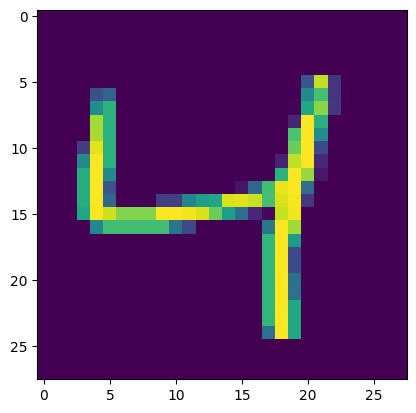

In [8]:
# Converts a single image to a numpy array `input`
input = np.array(train_images[2:3].reshape(1, 28, 28, 1), np.uint8)
print(runner.model.input(0).shape)
print(input.shape)

# Show the input image
test_image = input.reshape(28, 28)
plt.figure()
plt.imshow(test_image, interpolation='nearest')

The following runs 100 inferences and measure their walltimes.

In [9]:
%%timeit -n100

idx = random.randint(0, 59999)
input = np.array(train_images[idx:idx+1].reshape(1, 28, 28, 1), np.uint8)
outputs = runner.run(input)

200 µs ± 7.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`runner.run()` returns a list of tensors, and this model has only one output tensor.

In [10]:
outputs = runner.run(input)
outputs

[array([[117, 151, 116, 120, 159, 117, 116, 142, 104, 133]], dtype=uint8)]

You can also handle the output as a list and you can access a specific tensor as following:

In [11]:
outputs[0]

array([[117, 151, 116, 120, 159, 117, 116, 142, 104, 133]], dtype=uint8)

As you can see, the output of MNIST model is a tensor shaped `(1, 10)`, each of elements is the probability of the corresponding number. Let's print out what number has the highest probability.

In [15]:
np.argmax(outputs[0])

4

The answer will be the same as you saw the above image.

`Runner` object will be holding the NPU device until `runner.close()` is called if you keep this notebook session. To run other notebook examples, please free the NPU device as following:

In [17]:
runner.close()

2024-11-05T06:47:02.496501Z  INFO furiosa_rt_core::driver::event_driven::coord: [Sess-0914199d] terminated
2024-11-05T06:47:02.505648Z  INFO furiosa_rt_core::npu::raw: NPU (npu:9:0-1) has been closed
2024-11-05T06:47:02.507086Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] stopped


True

You can also use `with` statement for resource management like this.

In [21]:
with create_runner('models/MNIST_MobileNet_v2_uint8_quant_without_avgpool_softmax.tflite') as runner:
    outputs = runner.run(input)
    print(f"\n\nInference Results: {outputs}\n\n")

2024-11-05T06:49:46.913602Z  INFO furiosa_rt_core::driver::event_driven::coord: FuriosaRT (v0.10.3, rev: 394c19392, built at: 2023-11-22T08:53:04Z) bootstrapping ...
2024-11-05T06:49:46.916152Z  INFO furiosa_rt_core::driver::event_driven::coord: Found furiosa-compiler (v0.10.1, rev: 8b00177, built at: 2024-05-28T06:18:01Z)
2024-11-05T06:49:46.916157Z  INFO furiosa_rt_core::driver::event_driven::coord: Found libhal (type: warboy, v0.12.0, rev: 56530c0 built at: 2023-11-16T12:34:03Z)
2024-11-05T06:49:46.916159Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-4] detected 1 NPU device(s):
2024-11-05T06:49:46.927738Z  INFO furiosa_rt_core::driver::event_driven::coord: - [0] npu:8:0-1 (warboy-b0-2pe, 128dpes, firmware: 1.7.8, e9f371e)
2024-11-05T06:49:46.928016Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-4] started
2024-11-05T06:49:46.929178Z  INFO furiosa::runtime: Saving the compilation log into /home/changmin/.local/state/furiosa/logs/compiler-20241105154946